# Beginning Simply

## Working with a set of images

### Finding a library

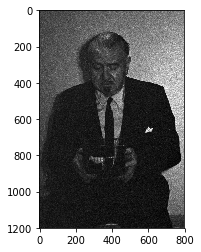

In [1]:
from skimage.io import imread
from skimage.transform import resize 
from matplotlib import pyplot as plt
import matplotlib.cm as cm

%matplotlib inline

example_file = ("http://upload.wikimedia.org/" +
    "wikipedia/commons/6/69/GeraldHeaneyMagician.png")
image = imread(example_file, as_grey=False)
plt.imshow(image, cmap=cm.gray)
plt.show()

### Dealing with image issues

In [2]:
from skimage import filters, restoration
from skimage.morphology import disk
median_filter = filters.rank.median(image, disk(1))
tv_filter = restoration.denoise_tv_chambolle(image,
                                             weight=0.1)
gaussian_filter = filters.gaussian(image, sigma=0.7)

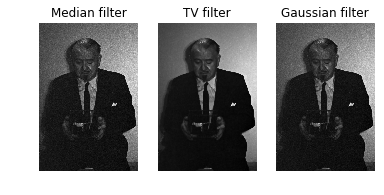

In [3]:
fig = plt.figure()
for k,(t,F) in enumerate((('Median filter',median_filter), 
              ('TV filter',tv_filter), 
              ('Gaussian filter', gaussian_filter))):
    f=fig.add_subplot(1,3,k+1)
    plt.axis('off')
    f.set_title(t)
    plt.imshow(F, cmap=cm.gray)
plt.show()

### Manipulating the image

In [4]:
print("data type: %s, dtype: %s, shape: %s" % 
      (type(image), image.dtype, image.shape))

data type: <class 'numpy.ndarray'>, dtype: uint8, shape: (1200, 800)


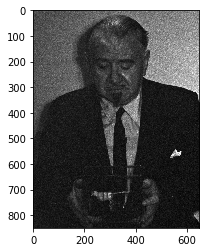

data type: <class 'numpy.ndarray'>, dtype: uint8, shape: (850, 650)


In [5]:
image2 = image[100:950,50:700]
plt.imshow(image2, cmap=cm.gray)
plt.show()
print("data type: %s, dtype: %s, shape: %s" % 
      (type(image2), image2.dtype, image2.shape))

data type: <class 'numpy.ndarray'>, dtype: float64, shape: (600, 460)


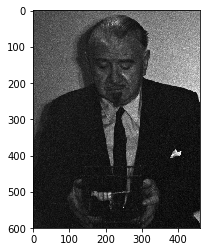

In [6]:
image3 = resize(image2, (600, 460), mode='symmetric')
plt.imshow(image3, cmap=cm.gray)
print("data type: %s, dtype: %s, shape: %s" % 
      (type(image3), image3.dtype, image3.shape))

In [7]:
image_row = image3.flatten()
print("data type: %s, shape: %s" % 
      (type(image_row), image_row.shape))

data type: <class 'numpy.ndarray'>, shape: (276000,)


## Extracting visual features

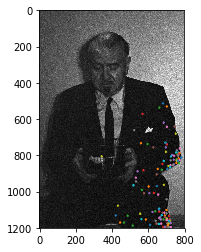

In [8]:
from skimage import measure
contours = measure.find_contours(image, 0.55)
plt.imshow(image, cmap=cm.gray)
for n, contour in enumerate(contours):
    plt.plot(contour[:, 1], contour[:, 0], linewidth=2)
plt.axis('image')
plt.show()

## Recognizing faces using Eigenfaces

In [9]:
import numpy as np
from sklearn.datasets import fetch_olivetti_faces
dataset = fetch_olivetti_faces(shuffle=True,
                               random_state=101)
train_faces = dataset.data[:350,:]
test_faces  = dataset.data[350:,:]
train_answers = dataset.target[:350]
test_answers = dataset.target[350:]

In [10]:
print (dataset.DESCR)

Modified Olivetti faces dataset.

The original database was available from

    http://www.cl.cam.ac.uk/research/dtg/attarchive/facedatabase.html

The version retrieved here comes in MATLAB format from the personal
web page of Sam Roweis:

    http://www.cs.nyu.edu/~roweis/

There are ten different images of each of 40 distinct subjects. For some
subjects, the images were taken at different times, varying the lighting,
facial expressions (open / closed eyes, smiling / not smiling) and facial
details (glasses / no glasses). All the images were taken against a dark
homogeneous background with the subjects in an upright, frontal position (with
tolerance for some side movement).

The original dataset consisted of 92 x 112, while the Roweis version
consists of 64x64 images.



In [11]:
from sklearn.decomposition import PCA
n_components = 25
Rpca = PCA(svd_solver='randomized', 
           n_components=n_components, 
           whiten=True,
           random_state=101).fit(train_faces)
print ('Explained variance by %i components: %0.3f' % 
       (n_components,
        np.sum(Rpca.explained_variance_ratio_)))
compressed_train_faces = Rpca.transform(train_faces)
compressed_test_faces  = Rpca.transform(test_faces)

Explained variance by 25 components: 0.794


We are looking for face id=34


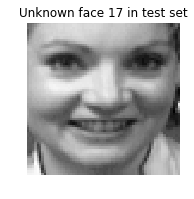

In [12]:
import matplotlib.pyplot as plt
photo = 17 # This is the photo in the test set
print ('We are looking for face id=%i' 
       % test_answers[photo])
plt.subplot(1, 2, 1)
plt.axis('off')
plt.title('Unknown face '+str(photo)+' in test set')
plt.imshow(test_faces[photo].reshape(64,64),
           cmap=plt.cm.gray, interpolation='nearest')
plt.show()

In [13]:
#Just the vector of value components of our photo
mask = compressed_test_faces[photo,] 
squared_errors = np.sum(
    (compressed_train_faces - mask)**2,axis=1)
minimum_error_face = np.argmin(squared_errors)
most_resembling = list(np.where(squared_errors < 20)[0])
print ('Best resembling face in train test: %i' % 
       train_answers[minimum_error_face])

Best resembling face in train test: 34


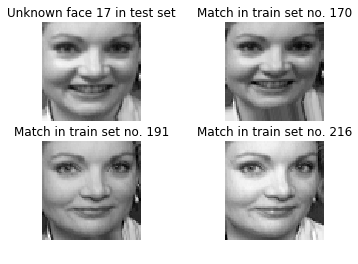

In [14]:
import matplotlib.pyplot as plt
plt.subplot(2, 2, 1)
plt.axis('off')
plt.title('Unknown face '+str(photo)+' in test set')
plt.imshow(test_faces[photo].reshape(64,64), 
           cmap=plt.cm.gray, interpolation='nearest')
for k,m in enumerate(most_resembling[:3]):
   plt.subplot(2, 2, 2+k)
   plt.title('Match in train set no. '+str(m))
   plt.axis('off')
   plt.imshow(train_faces[m].reshape(64,64), 
              cmap=plt.cm.gray, interpolation='nearest')
plt.show()

## Classifying images

In [15]:
import warnings
warnings.filterwarnings("ignore")
from sklearn.datasets import fetch_lfw_people
lfw_people = fetch_lfw_people(min_faces_per_person=60,
                              resize=0.4)
X = lfw_people.data
y = lfw_people.target
target_names = [lfw_people.target_names[a] for a in y]
n_samples, h, w = lfw_people.images.shape
from collections import Counter
for name, count in Counter(target_names).items():
    print ("%20s %i" % (name, count))

        Colin Powell 236
       George W Bush 530
         Hugo Chavez 71
   Junichiro Koizumi 60
          Tony Blair 144
        Ariel Sharon 77
     Donald Rumsfeld 121
   Gerhard Schroeder 109


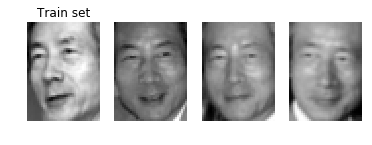

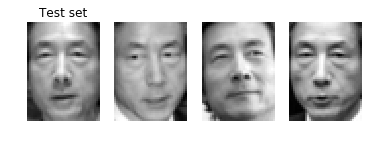

In [17]:
from sklearn.cross_validation import \
    StratifiedShuffleSplit
train, test = list(StratifiedShuffleSplit(target_names, 
            n_iter=1, test_size=0.1, random_state=101))[0]

plt.subplot(1, 4, 1)
plt.axis('off')
for k,m in enumerate(X[train][y[train]==6][:4]):
    plt.subplot(1, 4, 1+k)
    if k==0:
        plt.title('Train set')
    plt.axis('off')
    plt.imshow(m.reshape(50,37), 
               cmap=plt.cm.gray, interpolation='nearest')
plt.show()

for k,m in enumerate(X[test][y[test]==6][:4]):
    plt.subplot(1, 4, 1+k)
    if k==0:
        plt.title('Test set')
    plt.axis('off')
    plt.imshow(m.reshape(50,37), 
               cmap=plt.cm.gray, interpolation='nearest')
plt.show()

In [18]:
from sklearn import decomposition
n_components = 50
pca = decomposition.PCA(
    svd_solver='randomized',
    n_components=n_components,
    whiten=True).fit(X[train,:])
nmf = decomposition.NMF(n_components=n_components, 
                        init='nndsvda', 
                        tol=5e-3).fit(X[train,:])
fastica = decomposition.FastICA(n_components=n_components,
                              whiten=True).fit(X[train,:])
eigenfaces = pca.components_.reshape((n_components, h, w))
X_dec = np.column_stack((pca.transform(X[train,:]), 
        nmf.transform(X[train,:]),
        fastica.transform(X[train,:])))
Xt_dec = np.column_stack((pca.transform(X[test,:]), 
        nmf.transform(X[test,:]),
        fastica.transform(X[test,:])))
y_dec = y[train]
yt_dec = y[test]

In [19]:
from sklearn.grid_search import GridSearchCV
from sklearn.svm import SVC
param_grid = {'C': [0.1, 1.0, 10.0, 100.0, 1000.0],
              'gamma': [0.0001, 0.001, 0.01, 0.1], }
clf = GridSearchCV(SVC(kernel='rbf'), param_grid)
clf = clf.fit(X_dec, y_dec)
print ("Best parameters: %s" % clf.best_params_)

Best parameters: {'C': 10.0, 'gamma': 0.01}


In [20]:
from sklearn.metrics import accuracy_score
solution = clf.predict(Xt_dec)
print("Achieved accuracy: %0.3f" 
      % accuracy_score(yt_dec, solution))

Achieved accuracy: 0.837


In [21]:
from sklearn.metrics import confusion_matrix
confusion = str(confusion_matrix(yt_dec, solution))
print (' '*26+ '  '.join(map(str,range(8))))
print (' '*26+ '-'*22)
for n, (label, row) in enumerate(
                    zip(lfw_people.target_names,
                    confusion.split('\n'))):
    print ('%s %18s > %s' % (n, label, row))

                          0  1  2  3  4  5  6  7
                          ----------------------
0       Ariel Sharon > [[ 7  0  0  0  1  0  0  0]
1       Colin Powell >  [ 0 22  0  2  0  0  0  0]
2    Donald Rumsfeld >  [ 0  0  8  2  1  0  0  1]
3      George W Bush >  [ 0  1  3 46  1  0  0  2]
4  Gerhard Schroeder >  [ 0  0  2  1  6  1  0  1]
5        Hugo Chavez >  [ 0  0  0  0  0  6  0  1]
6  Junichiro Koizumi >  [ 0  0  0  0  0  0  6  0]
7         Tony Blair >  [ 0  0  0  1  1  0  0 12]]


# Moving to CNN with Character Recognition

## Accessing the dataset

Using TensorFlow backend.


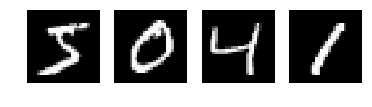

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
from keras.datasets import mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()

plt.plot()
plt.axis('off')
for k, m in enumerate(X_train[:4]):
    plt.subplot(1, 4, 1+k)
    plt.axis('off')
    plt.imshow(m, cmap=plt.cm.gray)
    
plt.show()

## Reshaping the dataset

In [2]:
import numpy
from keras.utils import np_utils

numpy.random.seed(100)

pixels = X_train.shape[1] * X_train.shape[2]
train_entries = X_train.shape[0]
test_entries = X_test.shape[0]
X_train_row = X_train.reshape(train_entries, pixels)
X_test_row = X_test.reshape(test_entries, pixels)

print(X_train_row.shape)
print(X_test_row.shape)

(60000, 784)
(10000, 784)


In [3]:
# Change the data type
X_train_row = X_train_row.astype('float32')
X_test_row = X_test_row.astype('float32')

# Perform the normalization.
X_train_row = X_train_row / 255
X_test_row = X_test_row / 255

## Encoding the categories

In [4]:
y_train_cat = np_utils.to_categorical(y_train)
y_test_cat = np_utils.to_categorical(y_test)
num_classes = y_test_cat.shape[1]
print(num_classes)
print(y_test[0])
print(y_test_cat[0])

10
7
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


## Creating the model

In [5]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout

def baseline_model():
    # Specify which model to use.
    model = Sequential()
    
    # Add layers to the model.
    model.add(Dense(pixels, input_dim=pixels, 
                    kernel_initializer='normal', 
                    activation='relu'))
    model.add(Dense(num_classes, 
                    kernel_initializer='normal', 
                    activation='softmax'))

    # Compile the model
    model.compile(loss='categorical_crossentropy', 
                  optimizer='adam', metrics=['accuracy'])
    return model

## Using the model

In [6]:
model = baseline_model()

model.fit(X_train_row, y_train_cat, 
          validation_data=(X_test_row, y_test_cat), 
          epochs=10, batch_size=200, verbose=2)

scores = model.evaluate(X_test_row, y_test_cat, verbose=0)
print("Baseline Error: %.2f%%" % (100-scores[1]*100))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
 - 13s - loss: 0.2800 - acc: 0.9205 - val_loss: 0.1344 - val_acc: 0.9623
Epoch 2/10
 - 13s - loss: 0.1116 - acc: 0.9681 - val_loss: 0.0916 - val_acc: 0.9722
Epoch 3/10
 - 12s - loss: 0.0716 - acc: 0.9794 - val_loss: 0.0730 - val_acc: 0.9775
Epoch 4/10
 - 12s - loss: 0.0501 - acc: 0.9854 - val_loss: 0.0677 - val_acc: 0.9776
Epoch 5/10
 - 12s - loss: 0.0360 - acc: 0.9902 - val_loss: 0.0615 - val_acc: 0.9812
Epoch 6/10
 - 12s - loss: 0.0264 - acc: 0.9929 - val_loss: 0.0643 - val_acc: 0.9794
Epoch 7/10
 - 12s - loss: 0.0188 - acc: 0.9957 - val_loss: 0.0616 - val_acc: 0.9802
Epoch 8/10
 - 12s - loss: 0.0144 - acc: 0.9967 - val_loss: 0.0609 - val_acc: 0.9811
Epoch 9/10
 - 12s - loss: 0.0106 - acc: 0.9978 - val_loss: 0.0614 - val_acc: 0.9820
Epoch 10/10
 - 13s - loss: 0.0087 - acc: 0.9980 - val_loss: 0.0587 - val_acc: 0.9813
Baseline Error: 1.87%


# Explaining How Convolutions Work

## Describing the LeNet architecture

### Building your own LeNet5 network

In [7]:
import keras
import numpy as np
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Conv2D, AveragePooling2D 
from keras.layers import Dense, Flatten
from keras.losses import categorical_crossentropy

In [8]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [9]:
num_classes = len(np.unique(y_train))
print(y_train[0], end=' => ')
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)
print(y_train[0])

5 => [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


In [10]:
X_train = X_train.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
img_rows, img_cols = X_train.shape[1:]
X_train = X_train.reshape(len(X_train), 
                          img_rows, img_cols, 1)
X_test = X_test.reshape(len(X_test), 
                        img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)

In [11]:
lenet = Sequential()

In [12]:
lenet.add(Conv2D(6, kernel_size=(5, 5), activation='tanh', 
      input_shape=input_shape, padding='same', name='C1'))

In [13]:
lenet.add(AveragePooling2D(
    pool_size=(2, 2), strides=(1, 1), padding='valid'))

In [14]:
lenet.add(Conv2D(16, kernel_size=(5, 5), strides=(1, 1), 
                 activation='tanh', padding='valid'))
lenet.add(AveragePooling2D(
    pool_size=(2, 2), strides=(1, 1), padding='valid')) 

In [15]:
lenet.add(Conv2D(120, kernel_size=(5, 5),
                 activation='tanh', name='C5'))
lenet.add(Flatten())

In [16]:
lenet.add(Dense(84, activation='tanh', name='FC6'))
lenet.add(Dense(10, activation='softmax', name='OUTPUT'))

In [17]:
lenet.compile(loss=categorical_crossentropy, 
              optimizer='SGD', metrics=['accuracy'])
lenet.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
C1 (Conv2D)                  (None, 28, 28, 6)         156       
_________________________________________________________________
average_pooling2d_1 (Average (None, 27, 27, 6)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 23, 23, 16)        2416      
_________________________________________________________________
average_pooling2d_2 (Average (None, 22, 22, 16)        0         
_________________________________________________________________
C5 (Conv2D)                  (None, 18, 18, 120)       48120     
_________________________________________________________________
flatten_1 (Flatten)          (None, 38880)             0         
_________________________________________________________________
FC6 (Dense)                  (None, 84)                3266004   
__________

In [18]:
batch_size = 64
epochs = 50
history = lenet.fit(X_train, y_train,
                      batch_size=batch_size,
                      epochs=epochs,
                      validation_data=(X_test, 
                                       y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 360s 6ms/step - loss: 0.3615 - acc: 0.8970 - val_loss: 0.2126 - val_acc: 0.9388
Epoch 2/50
60000/60000 [==============================] - 358s 6ms/step - loss: 0.1910 - acc: 0.9459 - val_loss: 0.1627 - val_acc: 0.9540
Epoch 3/50
60000/60000 [==============================] - 352s 6ms/step - loss: 0.1516 - acc: 0.9585 - val_loss: 0.1388 - val_acc: 0.9603
Epoch 4/50
60000/60000 [==============================] - 350s 6ms/step - loss: 0.1274 - acc: 0.9650 - val_loss: 0.1219 - val_acc: 0.9659
Epoch 5/50
60000/60000 [==============================] - 348s 6ms/step - loss: 0.1101 - acc: 0.9705 - val_loss: 0.1066 - val_acc: 0.9696
Epoch 6/50
60000/60000 [==============================] - 351s 6ms/step - loss: 0.0954 - acc: 0.9745 - val_loss: 0.0951 - val_acc: 0.9725
Epoch 7/50
60000/60000 [==============================] - 348s 6ms/step - loss: 0.0838 - acc: 0.9781 - val_loss: 0.0885 - 

In [19]:
print("Best validation accuracy: {:0.3f}"
       .format(np.max(history.history['val_acc'])))

Best validation accuracy: 0.988


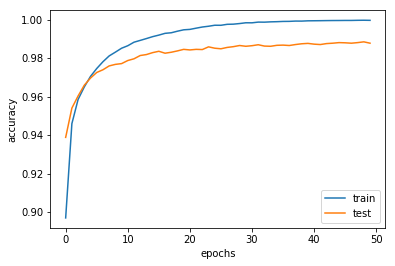

In [21]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.ylabel('accuracy'); plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='lower right')
plt.show()